# Analisis de la base de datos

# Primeros pasos

#### Empezemos por importar las librerias y cargar el DataFrame.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from script_funciones import scattered, catplot, matrix_corr, pplot, \
    limpieza, estandarizacion, grafico_acc, boxplot, estandarizacion_muestras

pd.set_option('display.width', 1000)

df = pd.read_csv('./csvs/transf_data.csv', sep=',')

Primer vistazo de los datos.

In [ ]:
print('\n','Drescripcion del DF sin procesar', '\n\n', df.describe(), sep='')
print('\n','15 Primeras filas', '\n\n',df.head(15), sep='')
nans = df[df.columns[df.isnull().any()]]
print('\n','NaNs por columna', '\n\n',(nans.isnull().sum()), sep='')

En un principio, teniamos 1.000.000 de datos! Lo primero que hicimos fue reducir la cantidad. Primero llamamos a 'borrador_samples', que se ocupa de iterar por el DataFrame guardando las primeras 820.000 posiciones donde haya 0 en la columna de 'fraud', despues borra las filas completas del DataFrame y lo retorna. ¿Por que hacemos esto? Aproximadamente 910.000 datos, concluian en no ser fraudes por transacciones. Concluimos en que tener 100.000 y 
80.000 datos de cada tipo, era mas que suficiente para entrenar la red.
Despues de este llamado, quedamos con 251.648 datos para utilizar. Mas tarde, llamaremos a 'limpieza', que se ocupa de borrar los atipicos de todas las columnas, quedandonos en total 180.304 datos.
El codigo de abajo fue utilizado para limpiar el CSV. Ahora en la carpeta, hay dos CSV, el original, y el extraido, generado gracias a la limpieza.

    # borra 820_000 datos de ceros
    # para dejar aproximadamente 80k y 80k
    df = borrador_samples(df)
    df = limpieza(df)
    df.to_csv('transf_data.csv', index=False)

Una vez realizada una limpieza general, podemos visualizar mejor los datos.

In [ ]:
scattered(df, 3)

In [ ]:
catplot(df, last_col=3, hue='fraud')

In [ ]:
matrix_corr(df)

Ahora que ya tenemos una idea del DataFrame, podemos darnos cuenta de que no hace falta tratar mucho mas los datos. Vamos a proceder a borrar los atipicos como ya habiamos dicho, con la funcion 'limpieza', para despues estandarizarlos con la funcion del script 'estandarizacion', la cual itera por cada columna, cargando en una lista los datos realizando la siguiente cuenta: ((dato - media) / desviacion estandar), para despues reasignar la lista nueva a cada columna.

In [ ]:
# Esto se va a usar mas adelante, para normalizar las predicciones
medias = []
desviaciones = []
df = limpieza(df)
df, medias, desviaciones = estandarizacion(df)

Verifiquemos como quedaron los datos

In [ ]:
print('\n','Drescripcion del DF post procesamiento', '\n\n', df.describe(), sep='')
print('\n','15 Primeras filas', '\n\n',df.head(15), sep='')
nans = df[df.columns[df.isnull().any()]]
print('\n','NaNs por columna', '\n\n',(nans.isnull().sum()), sep='')

# RED NEURONAL

Ahora si, la _**Red Neuronal**_. Primero vamos a separar los datos en entrenamiento y testeo, para despues definiar la funcion para entrenar la red.
Se van a definir valores random para la capa oculta y los sesgos. Estos valores se multiplican por 2 y se les resta uno, para obtener asi tambien valores negativos. Una vez definidas las funciones ReLu y Sigmoide, armamos la funcion del _**Forward Propagation**_, la cual aplica las multiplicaciones matriciales correspondientes hasta llegar a la salida, y _**Backward Propagation**_, que se encarga de redistribuir el error entre las capas utilizando las derivadas, actualizando los pesos y sesgos para un error menor la proxima iteracion.

#### Arquitectura de la red
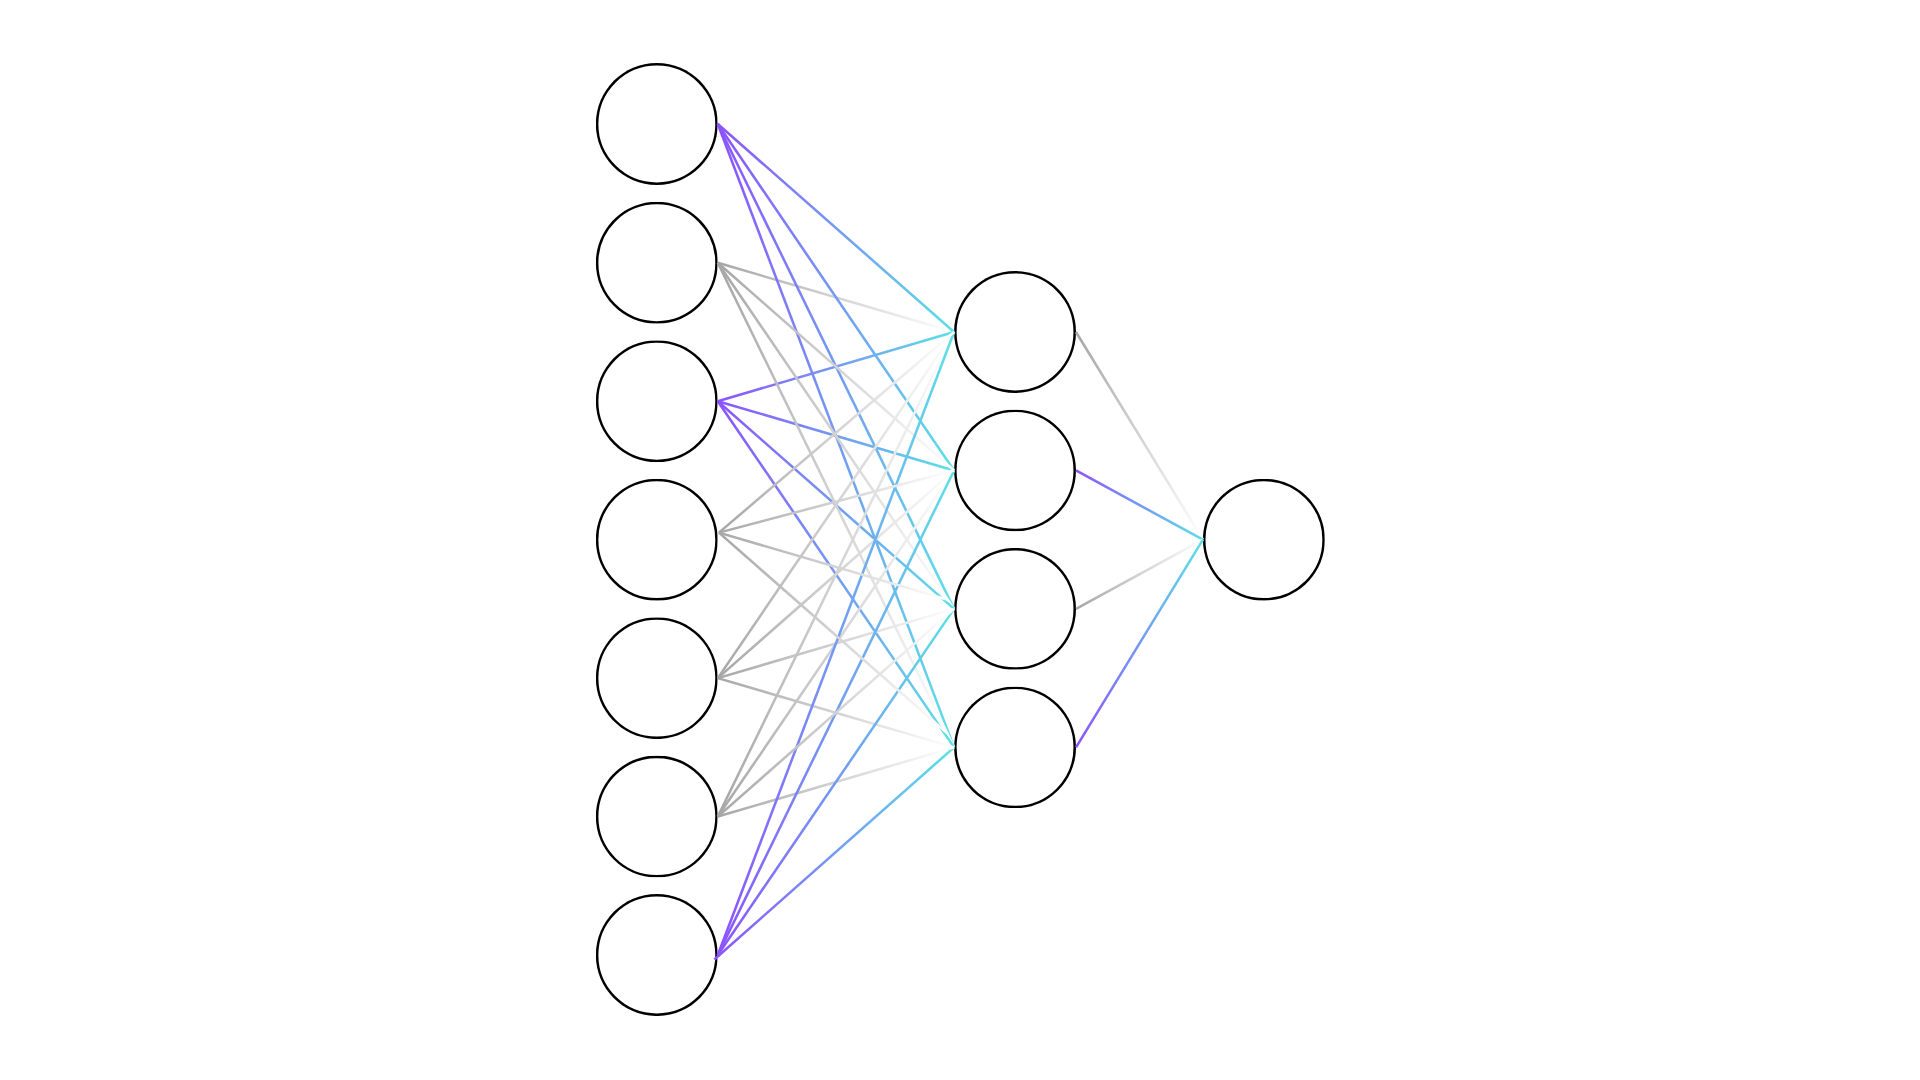
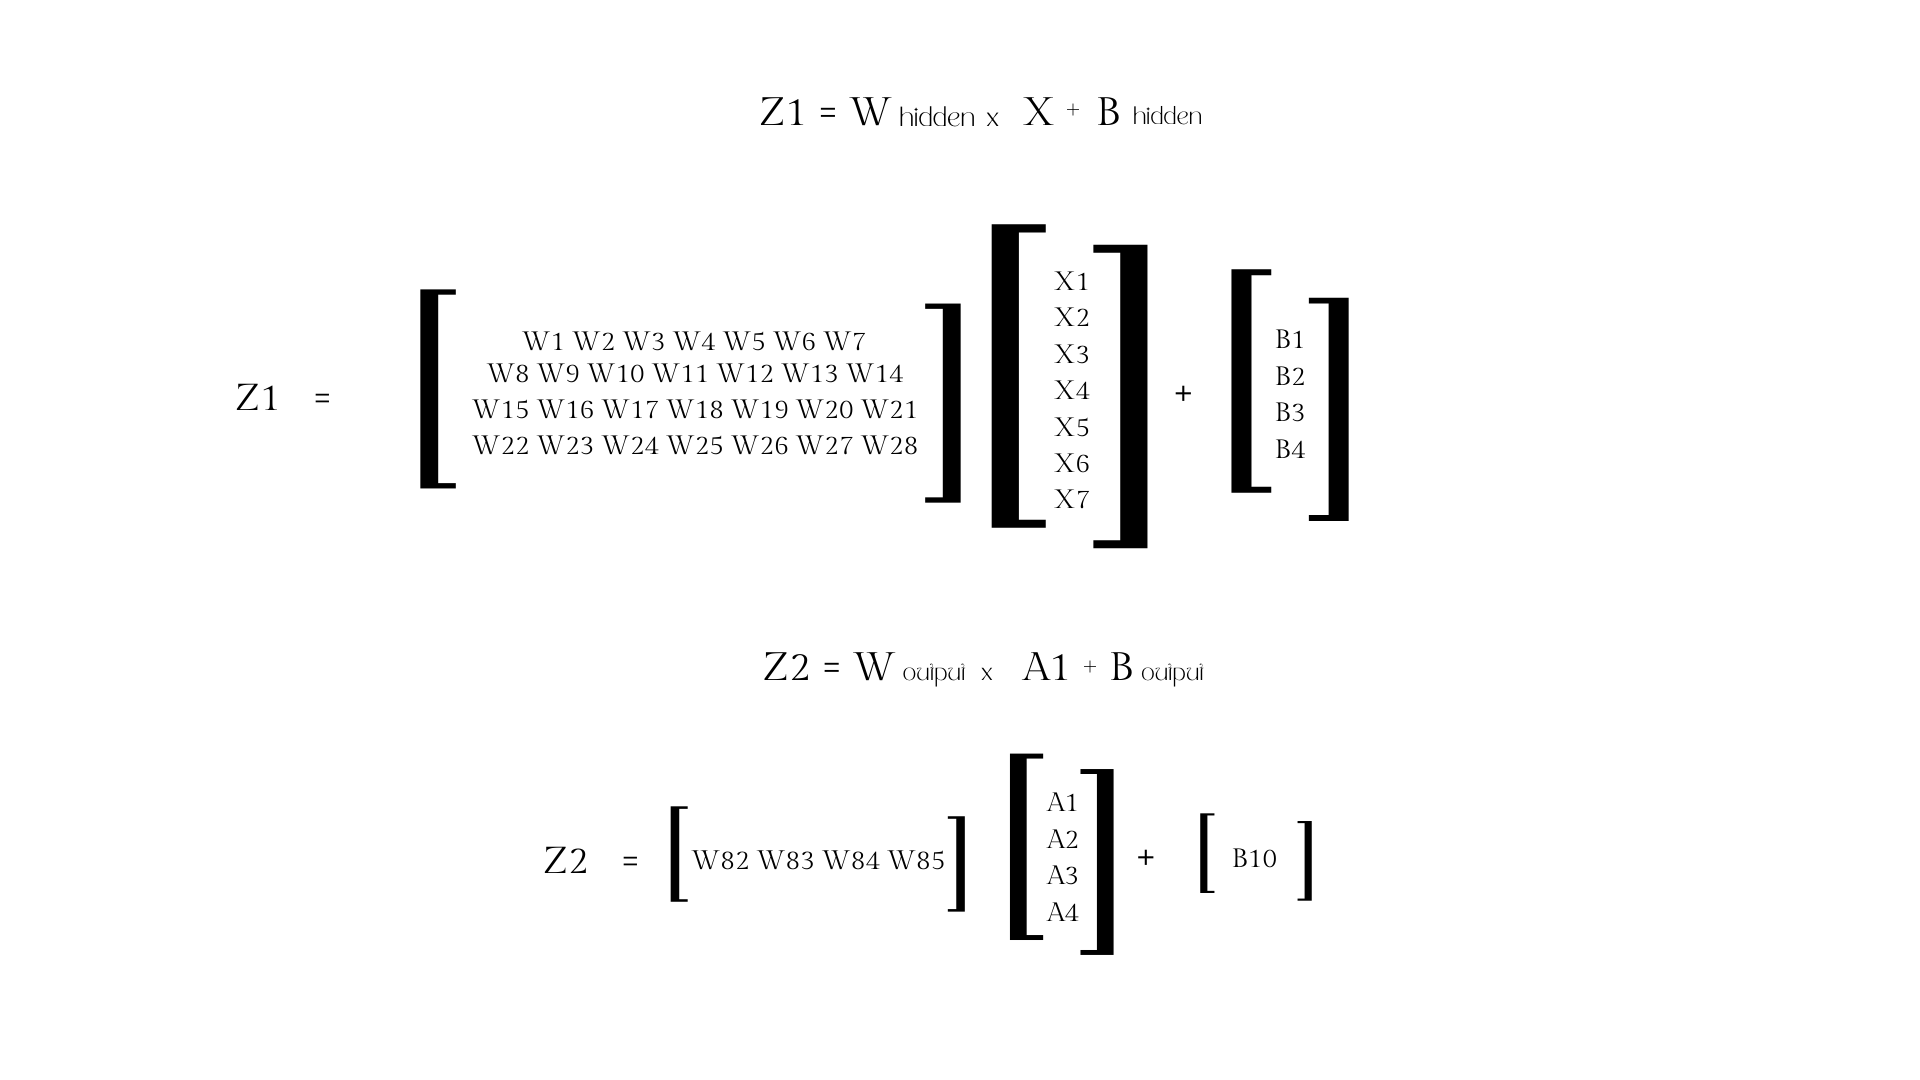

- Capas
    - La red dispone de 3 capas: 1 de entrada, 1 capa oculta y 1 de salida.

- Neuronas
    - En la capa de entrada habra 7 neuronas (datos de entrada), en la capa oculta, habra 4 neuronas, y en la ultima 1 sola, ya que es 1 si es fraude o 0 si no lo es.

- Funciones de Activacion
    - ReLu en las ocultas, Sigmoide en la de salida

Comenzamos con la red.
Primero, separamos los datos en entrenamiento y testeo.

In [ ]:
# Extraigo las columnas de entrada
inputs = df.iloc[:, 0:7].values
outputs = df.iloc[:, -1].values

# Conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=1/3)

#shape retorna una tupla con las dimensiones de la matriz = (filas, columnas).
# por lo que shape[0], nos retorna las filas de la matriz.
n_train = x_train.shape[0] # numero de registros de entrenamiento

Y ahora si, construimos la Red Neuronal.

In [ ]:
def red_neuronal(L, epochs):
    np.random.seed(0)
    # pesos
    w_hidden_1 = np.random.rand(4,7) * 2 - 1
    w_output_1 = np.random.rand(1,4) * 2 - 1

    # sesgos
    b_hidden = np.random.rand(4,1) * 2 - 1
    b_output = np.random.rand(1,1) * 2 - 1

    # Funciones de Activacion
    relu = lambda x: np.maximum(x, 0)
    sigmoide = lambda x: 1 / (1 + np.exp(-x))

    def f_prop(X):
        z1 = w_hidden_1 @ X + b_hidden
        a1 = relu(z1)
        z2 = w_output_1 @ a1 + b_output
        a2 = sigmoide(z2)
        return z1, a1, z2, a2

    # Derivadas de las funciones de activación
    d_relu = lambda x: x > 0
    d_sigmoide = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    # Devuelve pendientes para pesos y sesgos
    # usando la regla de la cadena
    def b_prop(z1, a1, z2, a2, X, Y):
        dC_dA2 = 2 * a2 - 2 * Y
        dA2_dZ2 = d_sigmoide(z2)
        dZ2_dA1 = w_output_1
        dZ2_dW2 = a1
        dZ2_dB2 = 1
        dA1_dZ1 = d_relu(z1)
        dZ1_dW1 = X
        dZ1_dB1 = 1

        dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T
        dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2
        dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1
        dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T
        dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

        return dC_dW1, dC_dB1, dC_dW2, dC_dB2

    # Para el grafico de las funciones
    accuracy_train_l = []
    accuracy_test_l = []

    # Ejecutar descenso de gradiente
    for i in range(epochs):
        # seleccionar aleatoriamente uno de los datos de entrenamiento
        idx = np.random.choice(n_train, 1, replace=False)
        X_sample = x_train[idx].transpose()
        Y_sample = y_train[idx]
        
        # pasar datos seleccionados aleatoriamente a través de la red neuronal
        Z1, A1, Z2, A2 = f_prop(X_sample)

        # distribuir error a través de la retropropagación
        # y devolver pendientes para pesos y sesgos
        dW1, dB1, dW2, dB2 = b_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

        # actualizar pesos y sesgos
        w_hidden_1 -= L * dW1
        b_hidden -= L * dB1
        w_output_1 -= L * dW2
        b_output -= L * dB2

        # Accuracy
        # Test
        test_predictions = f_prop(x_test.transpose())[3]
        test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), y_test)
        accuracy_test = sum(test_comparisons.astype(int) / x_test.shape[0])
        accuracy_test_l.append(accuracy_test)
        
        # Train
        train_predictions = f_prop(x_train.transpose())[3]
        train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), y_train)
        
        accuracy_train = sum(train_comparisons.astype(int) / x_train.shape[0])
        accuracy_train_l.append(accuracy_train)

    print("TRAIN ACCURACY: ", accuracy_train)
    print("TEST ACCURACY: ", accuracy_test)
    print(f'Epochs: {epochs}')
    print(f'Paso: {L}')
    grafico_acc(L=L, train_l=accuracy_train_l, test_l=accuracy_test_l)
    return w_hidden_1, b_hidden, w_output_1, b_output


Y ahora si, procedemos a entrenar la red

In [ ]:
# ================================================
# Estos se van a usar despues para llamar solamente
# a la funcion de forward prop con los pesos y sesgos
# que salgan de la red entrenada
w_h = 0
b_h = 0
w_o = 0
b_o = 0
relu = lambda x: np.maximum(x, 0)
sigmoide = lambda x: 1 / (1 + np.exp(-x))
# =================================================
epochs = [2500]
eles = [.03]
for rep in epochs:
    for ele in eles:
        w_h, b_h, w_o, b_o = red_neuronal(L=ele, epochs=rep)

In [ ]:
# La redefino afuera para poder llamarla con muestras nuevas
def f_prop(X):
        z1 = w_h @ X + b_h
        a1 = relu(z1)
        z2 = w_o @ a1 + b_o
        a2 = sigmoide(z2)
        return z1, a1, z2, a2

In [ ]:
# Y ahora podemos predecir muestras nuevas
def predictor(dist_h, dist_t, ratio, repeat_r, chip, pin, online):
    X = np.array([[dist_h, dist_t, ratio, repeat_r, chip, pin, online]]).transpose()
    X = pd.DataFrame(X)
    X = estandarizacion_muestras(X, medias, desviaciones)
    X = X.to_numpy()
    Z1, A1, Z2, A2 = f_prop(X)
    return A2

def red_predict(dist_h, dist_t, ratio, repeat_r, chip, pin, online):
    prediccion = predictor(dist_h, dist_t, ratio, repeat_r, chip, pin, online)
    print(prediccion)
    if prediccion < .5:
        print('Transaccion Segura')
    else:
        print('Transaccion Insegura')




Con esto podemos probar la Red. Se le puede pasar 7 valores random (teniendo en cuenta que los ultimos 3 son valores categoricos) Y ver la salida de la red. Se recomienda probar con las muestras de 'card_transdata.csv', ya que son muestras reales. La salida, deberia ser la misma que la del CSV. (Con el mismo accuracy que tengamos al entrenar la red. Si nosotros tuvimos un 97%, le va a pegar con esa frecuencia, si fue menos, va a ser menos.)
Valores recomendados para el entrenamiento de la red:

Accuracy 97.4% => Step 0.03, epochs 3500

Accuracy 97.8% => Step 0.03, epochs 10000


In [ ]:
red_predict(10.664473716016785,1.5657690862016613,4.886520843107555,1.0,0.0,0.0,1.0)